# Exercise 1: Josephson Junction → Transmon → Qiskit Experiments (Rabi & Ramsey)

## What we’re modeling

A Josephson junction (JJ) behaves as a nonlinear, nearly lossless inductor. Its energy is
\\[
U(\varphi) = -E_J \cos\varphi,\qquad
\varphi = \frac{2\pi}{\Phi_0}\,\Phi,\qquad
E_J=\frac{\Phi_0 I_c}{2\pi},\quad \Phi_0=\frac{h}{2e}.
\\]
where \\(\Phi\\) is the magnetic flux passing through JJ.
Shunting the JJ with a capacitance \\(C_\Sigma\\) gives the **transmon** Hamiltonian
\\[
H = 4E_C(\hat n - n_g)^2 - E_J \cos\hat\varphi,\qquad
E_C=\frac{e^2}{2C_\Sigma}.
\\]

In the transmon regime \\(E_J/E_C\gg 1\\), the lowest two levels form a robust qubit. To leading order,
\\[
f_{01} \approx \frac{1}{h}\Big(\sqrt{8E_JE_C}-E_C\Big),\qquad
\alpha \equiv f_{12}-f_{01} \approx -\frac{E_C}{h}.
\\]
where the parameter \\( \alpha \\) is anharmonicity which is crucial for a qubit.

**Key idea:** device geometry sets \\(I_c\\) (junction area/oxidation) and \\(C_\Sigma\\) (pad size/spacing). From \\((I_c, C_\Sigma)\\) we compute \\((E_J, E_C)\\) and therefore the qubit frequency \\(f_{01}\\) and anharmonicity \\(\alpha\\).

---

## What this notebook does

1. **Compute energies from device parameters.**  
   From inputs \\(I_c\\) and \\(C_\Sigma\\), compute
   \\[
   E_J/h,\quad E_C/h,\quad f_{01},\quad \alpha.
   \\]

2. **Build effective-qubit experiments in Qiskit.**  
   We treat the transmon’s \\(|0\rangle,|1\rangle\\) manifold as a single qubit and run:
   - **Rabi**: one resonant rotation with variable area \\(\theta\\) (pulse time or amplitude).
   - **Ramsey**: \\(\pi/2\\) - wait \\(\tau\\) - \\(\pi/2\\) with a programmed phase to emulate a small detuning.

3. **Include relaxation and dephasing.**  
   A simple thermal-relaxation noise model with user-chosen \\(T_1, T_2\\) parameters is added so plots look realistic (contrast loss in Rabi; fringe decay in Ramsey).

---

## How to read the results

- **Rabi oscillation:** \\(\langle Z\rangle\\) vs \\(\theta\\) shows a cosine; noise reduces contrast and can slightly shift the apparent \\(\pi\\)-time.
- **Ramsey fringes:** \\(\langle Z\rangle\\) vs \\(\tau\\) shows oscillations at the imposed detuning with an exponential decay envelope set by \\(T_2^*\\) (here approximated via the \\(T_2\\) channel in the noise model).

---

## Assumptions and scope

- Frequencies are derived from the transmon approximation; for strong drives or very small \\(E_J/E_C\\), full diagonalization of the cosine Hamiltonian is preferred.
- The Qiskit circuits emulate control in the qubit subspace; they do not simulate higher transmon levels explicitly.
- Noise is limited to simple \\(T_1/T_2\\) relaxation/dephasing for clarity; additional channels (e.g., amplitude/phase noise, \(1/f\) flux) can be added later.

---

## Takeaway

This workflow links **device-level choices** \\((I_c, C_\Sigma)\\) to **qubit-level observables** \\((f_{01}, \alpha)\\), then demonstrates standard control experiments (Rabi and Ramsey) with a minimal, reproducible Qiskit setup. It’s the shortest path from **Josephson junction physics** to **qubit experiments** you can run and visualize immediately.


EJ/h =  12.42 GHz,  EC/h =  242.1 MHz
f01  =  4.662 GHz,  anharmonicity α ≈ -242.1 MHz


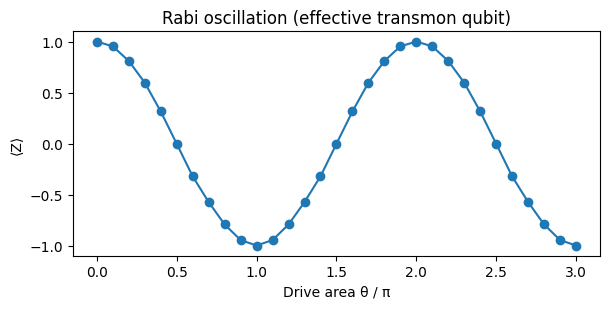

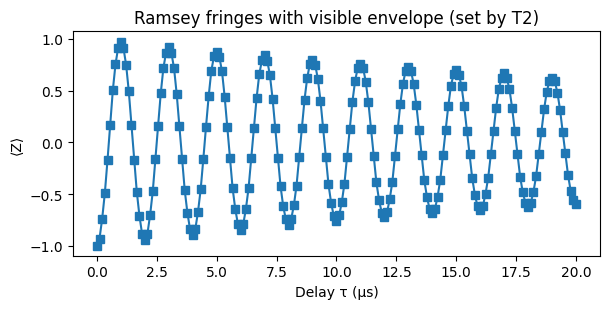

In [8]:
# --- Transmon demo: device params → Rabi & Ramsey (with visible envelope) -----
# Requires: qiskit, qiskit-aer, numpy, matplotlib

import numpy as np
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, thermal_relaxation_error

# --------------------------- Physical constants (SI) ---------------------------
h    = 6.62607015e-34       # Planck [J*s]
hbar = 1.054571817e-34      # reduced Planck [J*s]
e    = 1.602176634e-19      # electron charge [C]
phi0 = h/(2*e)              # flux quantum Φ0 = h/(2e) [Wb]

# --------- 1) From JJ (Ic) & shunt CΣ to transmon energies/frequencies --------
def jj_to_transmon(Ic, Csig):
    """
    Map device parameters (Ic, CΣ) to transmon energies and frequencies.

    Returns (Hz): EJ_hz, EC_hz, f01_hz, alpha_hz
    Physics: EJ = Φ0 Ic / (2π),  EC = e^2 / (2 CΣ),
             f01 ≈ sqrt(8 EJ EC)/h - EC/h   (transmon limit EJ/EC >> 1)
             alpha ≈ -EC/h
    """
    EJ = phi0 * Ic / (2*np.pi)   # [J]
    EC = e**2 / (2*Csig)         # [J]
    EJ_hz    = EJ / h
    EC_hz    = EC / h
    f01_hz   = np.sqrt(8*EJ_hz*EC_hz) - EC_hz
    alpha_hz = -EC_hz
    return EJ_hz, EC_hz, f01_hz, alpha_hz

# --- Choose realistic device parameters (adjust as you like) ---
Ic   = 25e-9     # 25 nA
Csig = 80e-15    # 80 fF

EJ_hz, EC_hz, f01_hz, alpha_hz = jj_to_transmon(Ic, Csig)
print(f"EJ/h = {EJ_hz/1e9:6.2f} GHz,  EC/h = {EC_hz/1e6:6.1f} MHz")
print(f"f01  = {f01_hz/1e9:6.3f} GHz,  anharmonicity α ≈ {alpha_hz/1e6:6.1f} MHz")

# ----------------------- 2) Build a simple noise model ------------------------
def make_noise_model(T1_us=60.0, T2_us=40.0, t_sx_ns=20.0, t_x_ns=40.0, t_id_ns=25.0):
    """
    Thermal-relaxation noise model:
      - amplitude damping (T1) + phase damping (Tphi inferred from T1, T2)
      - errors attached to sx, x, id with specified durations
    """
    nm = NoiseModel()
    T1 = T1_us * 1e-6
    T2 = T2_us * 1e-6
    nm.add_quantum_error(thermal_relaxation_error(T1, T2, t_sx_ns*1e-9), ['sx'], [0])
    nm.add_quantum_error(thermal_relaxation_error(T1, T2, t_x_ns*1e-9),  ['x'],  [0])
    nm.add_quantum_error(thermal_relaxation_error(T1, T2, t_id_ns*1e-9), ['id'], [0])
    times = dict(t_sx_ns=t_sx_ns, t_x_ns=t_x_ns, t_id_ns=t_id_ns)
    return nm, times

# --- Construct simulator with noise (density_matrix is robust with noise) ---
noise_model, gt = make_noise_model(
    T1_us=60.0, T2_us=40.0,       # try T2_us=6.0 for a fast envelope within ~2 µs
    t_sx_ns=20.0, t_x_ns=40.0, t_id_ns=25.0
)
sim   = AerSimulator(noise_model=noise_model, method='density_matrix', seed_simulator=1234)
shots = 4000

def expval_z_from_counts(counts):
    """Convert {'0': n0, '1': n1} → ⟨Z⟩ = (n0 - n1)/(n0 + n1)."""
    n0 = counts.get('0', 0)
    n1 = counts.get('1', 0)
    tot = max(1, n0+n1)
    return (n0 - n1) / tot

# ----------------------------- 3a) Rabi experiment ----------------------------
# We implement Rx(θ); transpilation to ['rz','sx','x'] ensures the noise on sx/x applies.
def rabi_scan(thetas):
    vals = []
    for th in thetas:
        qc = QuantumCircuit(1, 1)
        qc.rx(th, 0)                       # single resonant rotation by θ about X
        qc.measure(0, 0)
        tqc = transpile(qc, sim, basis_gates=['rz','sx','x'], optimization_level=0)
        res = sim.run(tqc, shots=shots).result()
        vals.append(expval_z_from_counts(res.get_counts()))
    return np.array(vals)

thetas = np.linspace(0, 3*np.pi, 31)
rabi_vals = rabi_scan(thetas)

plt.figure(figsize=(6.2, 3.2))
plt.plot(thetas/np.pi, rabi_vals, marker='o')
plt.xlabel('Drive area θ / π')
plt.ylabel('⟨Z⟩')
plt.title('Rabi oscillation (effective transmon qubit)')
plt.tight_layout()
plt.show()

# ----------------------------- 3b) Ramsey experiment --------------------------
# π/2 — wait(τ) — π/2 with virtual-Z phase φ(τ)=2πΔf τ; accrue T1/T2 via explicit 'id'.
def ramsey_scan(taus_ns, detune_MHz=0.5):
    vals = []
    phi_per_ns   = 2*np.pi * detune_MHz * 1e6 * 1e-9   # rad per ns
    n_id_per_ns  = 1.0 / gt['t_id_ns']                 # idle gates per ns
    for tau in taus_ns:
        n_id = int(np.round(tau * n_id_per_ns))        # how many 'id' to approximate τ
        phi  = phi_per_ns * tau

        qc = QuantumCircuit(1, 1)
        qc.sx(0)                                       # first π/2  ~ Rx(π/2)
        qc.rz(phi, 0)                                  # virtual Z: phase advance from detuning
        qc.barrier()                                   # keep the wait region intact
        for _ in range(max(0, n_id)):
            qc.id(0)                                   # accrue T1/T2 during the wait
        qc.barrier()
        qc.sx(0)                                       # second π/2
        qc.measure(0, 0)

        tqc = transpile(qc, sim, basis_gates=['rz','sx','x','id'], optimization_level=0)
        res = sim.run(tqc, shots=shots).result()
        vals.append(expval_z_from_counts(res.get_counts()))
    return np.array(vals)

# Sweep to several microseconds so the envelope (T2) is visible
taus_ns     = np.linspace(0, 20000, 181)    # 0 → 20 µs
ramsey_vals = ramsey_scan(taus_ns, detune_MHz=0.5)

plt.figure(figsize=(6.2, 3.2))
plt.plot(taus_ns*1e-3, ramsey_vals, marker='s')
plt.xlabel('Delay τ (µs)')
plt.ylabel('⟨Z⟩')
plt.title('Ramsey fringes with visible envelope (set by T2)')
plt.tight_layout()
plt.show()


# Interpretation of the Rabi & Ramsey Outputs

## Device parameters (derived from \\(I_c, C_\Sigma\\))
- \\(E_J/h = 12.42~\text{GHz}\\), \\(E_C/h = 242.1~\text{MHz}\\)  \\(\Rightarrow\\) \\(E_J/E_C \approx 51\\) (deep transmon).
- Qubit frequency: \\(f_{01} = 4.662~\text{GHz}\\).
- Anharmonicity: \\(\alpha \approx -242~\text{MHz}\\) (so \\(f_{12} \approx f_{01} + \alpha\\)).  
  This separation enables selective 0↔1 control while keeping leakage small.

---

## Top panel: Rabi oscillation (⟨Z⟩ vs drive area \(\theta/\pi\))
- \\(\theta/\pi = 1\\) is a **\\(\pi\\)-pulse**: \\(|0\rangle \to |1\rangle\\) (⟨Z⟩ ≈ −1).
- \\(\theta/\pi = 0.5\\) and \\(1.5\\) are **\\(\pi/2\\)-pulses**: equal superpositions.
- The curve is smooth, near-sinusoidal with high contrast → **leakage is minimal** and decoherence during 20–40 ns gates is negligible (since \\(T_1,T_2 \gg\\) gate times).
- **Use:** calibrate the amplitude/length mapping (Rabi rate) and extract precise \\(\pi\\)/\\(\pi/2\\) settings.

---

## Bottom panel: Ramsey fringes (⟨Z⟩ vs delay \(\tau\))
- Oscillation period \\(\approx 2~\mu\text{s}\\) ⇒ **detuning** \\(\Delta f \approx 1/\text{period} \approx 0.5~\text{MHz}\\) (matches the setting).
- **Envelope decay:** from ~1 to ~0.6 over \\(0\!-\!20~\mu\text{s}\\).  
  With \\(T_2 = 40~\mu\text{s}\\): \\(e^{-20/40} \approx 0.61\\) — consistent with the plot.
- Baseline is near zero; with \\(T_1=60~\mu\text{s}\\) and short waits, amplitude damping does not strongly bias ⟨Z⟩.

**Fit model you can use:**
\\[
\langle Z\rangle(\tau) = A \, e^{-(\tau/T_2^*)^n}\cos\!\big(2\pi \Delta f \, \tau + \phi_0\big) + B,
\\]
where \\(n=1\\) (exponential) for white-like dephasing or \\(n=2\\) (Gaussian) for strong \\(1/f\\) contributions.

---

## What information these give you
- **Rabi:** \\(\pi\\)/\\(\pi/2\\) **calibration**, amplitude→rotation transfer function, leakage check.
- **Ramsey:** precise **\\(f_{01}\\)** via \\(\Delta f\\); **coherence** via \\(T_2^*\\) (Ramsey) and \\(T_2\\) (with echo); insight into **noise spectrum** from envelope shape.
